In [3]:
import time
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
df = pd.read_csv('./dataset/Apply_Rate_2019.csv').drop('search_date_pacific', axis=1)
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,class_id
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0,-7613806991329176388
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0,-1361819269400927213
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1,-1361819269400927213
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0,-3623880078591607667
4,NaN,NaN,7.868900,0.008065,0.008772,0.0,7.0,0,-7054510112423797411


In [4]:
df.drop_duplicates(inplace=True)  # (len(df)=1112618, len(df[df['apply']==1])=99595), imbalanced
df.fillna(df.mean(), inplace=True)
df.head()

,title_proximity_tfidf,description_proximity_tfidf,main_query_tfidf,query_jl_score,query_title_score,city_match,job_age_days,apply,class_id
0,0.000000,0.000000,0.000000,0.004824,0.006628,0.0,5.0,0,-7613806991329176388
1,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,0,-1361819269400927213
2,11.874042,0.043637,2.527080,0.011935,0.011208,0.0,5.0,1,-1361819269400927213
3,0.000000,0.000000,3.695809,0.013046,0.033340,0.0,5.0,0,-3623880078591607667
4,5.958872,0.097365,7.868900,0.008065,0.008772,0.0,7.0,0,-7054510112423797411


In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=4211)
train_x = train.iloc[:,0:7]
train_y = train.iloc[:,7]

test_x = test.iloc[:,0:7]
test_y = test.iloc[:,7]

len(train_y), len(train_y[train_y==1])  # imbalanced

(890094, 79578)

In [8]:
# pre-processing
from imblearn.under_sampling import RandomUnderSampler
resampled_train_x, resampled_train_y = RandomUnderSampler(random_state=0).fit_resample(train_x, train_y)
resampled_train_x.shape

Using TensorFlow backend.


(159156, 7)

In [9]:
mlp = MLPClassifier(hidden_layer_sizes=(120, ), max_iter=500, learning_rate='adaptive', random_state=4211)

In [10]:
start = time.time()
mlp.fit(resampled_train_x, resampled_train_y)
print(time.time()-start)

48.768094539642334


0.6324036957811292 0.18794611390733737


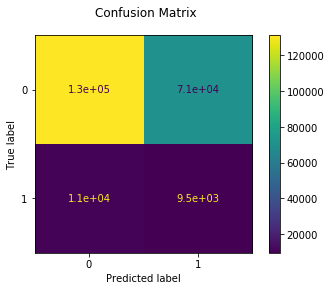

In [11]:
def printConfusion(clf, test_x, test_y):
    pred_y = clf.predict(test_x)

    acc = accuracy_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y)
    print(acc, f1)

    disp = plot_confusion_matrix(clf, test_x, test_y)
    disp.figure_.suptitle("Confusion Matrix")
    
printConfusion(mlp, test_x, test_y)